In [1]:
import matplotlib.pyplot as plt
import torch
from torch.nn import LSTM
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils_random import set_random_seed
from utils_torch.modules import LSTMLayer, LSTMLayerHiddenCell

In [2]:
set_random_seed(42)

In [3]:
hcLSTM = LSTMLayerHiddenCell(input_size=1,
                             hidden_size=16,
                             proj_size=1,
                             bidirectional=False,
                             batch_first=True)
hcOPTIM = torch.optim.Adam(hcLSTM.parameters())
hcLOSS = torch.nn.MSELoss()

/Users/zhoufang/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
set_random_seed(42)

In [5]:
ptLSTM = LSTMLayer(input_size=1,
                   hidden_size=16,
                   proj_size=1,
                   bidirectional=False,
                   batch_first=True)
ptOPTIM = torch.optim.Adam(ptLSTM.parameters())
ptLOSS = torch.nn.MSELoss()

In [6]:
set_random_seed(42)

In [7]:
nnLSTM = LSTM(input_size=1,
              hidden_size=16,
              proj_size=1,
              bidirectional=False,
              batch_first=True)
nnOPTIM = torch.optim.Adam(nnLSTM.parameters())
nnLOSS = torch.nn.MSELoss()

In [8]:
print("LSTMLayerHiddenCell:")
print("forward input-hidden weights equal: ", torch.equal(hcLSTM.forward_input_weights, nnLSTM.weight_ih_l0))
print("forward hidden-hidden weights equal: ", torch.equal(hcLSTM.forward_hidden_weights, nnLSTM.weight_hh_l0))
print("forward input-hidden bias equal: ", torch.equal(hcLSTM.forward_input_bias, nnLSTM.bias_ih_l0))
print("forward hidden-hidden bias equal: ", torch.equal(hcLSTM.forward_hidden_bias, nnLSTM.bias_hh_l0))
print("forward projection weights equal: ", torch.equal(hcLSTM.forward_projection_weights, nnLSTM.weight_hr_l0))

LSTMLayerHiddenCell:
forward input-hidden weights equal:  True
forward hidden-hidden weights equal:  True
forward input-hidden bias equal:  True
forward hidden-hidden bias equal:  True
forward projection weights equal:  True


In [9]:
print("LSTMLayer:")
print("forward input-hidden weights equal: ", torch.equal(ptLSTM.forward_input_weights, nnLSTM.weight_ih_l0))
print("forward hidden-hidden weights equal: ", torch.equal(ptLSTM.forward_hidden_weights, nnLSTM.weight_hh_l0))
print("forward input-hidden bias equal: ", torch.equal(ptLSTM.forward_input_bias, nnLSTM.bias_ih_l0))
print("forward hidden-hidden bias equal: ", torch.equal(ptLSTM.forward_hidden_bias, nnLSTM.bias_hh_l0))
print("forward projection weights equal: ", torch.equal(ptLSTM.forward_projection_weights, nnLSTM.weight_hr_l0))

LSTMLayer:
forward input-hidden weights equal:  True
forward hidden-hidden weights equal:  True
forward input-hidden bias equal:  True
forward hidden-hidden bias equal:  True
forward projection weights equal:  True


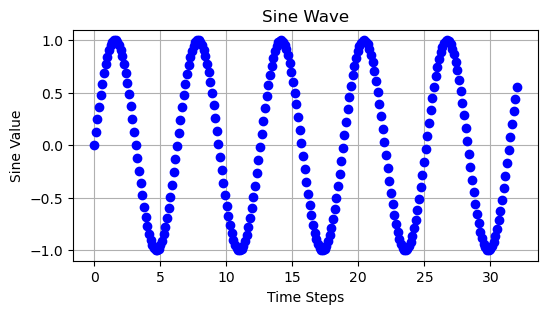

In [10]:
time_steps = 256
x = torch.linspace(0, 32, time_steps)
y = torch.sin(x)
plt.figure(figsize=(6, 3))
plt.plot(x, y, 'bo')
plt.xlabel("Time Steps")
plt.ylabel("Sine Value")
plt.title("Sine Wave")
plt.grid(True)
plt.show()

In [11]:
window_size = 32

In [12]:
num_samples = time_steps - window_size

In [13]:
data, label = [], []
for i in range(num_samples):
    data.append(y[i:i + window_size].unsqueeze(-1))
    label.append(y[i + window_size].unsqueeze(-1))
data_tensor, label_tensor = torch.stack(data), torch.stack(label)
data_loader, label_loader = DataLoader(data_tensor, batch_size=32), DataLoader(label_tensor, batch_size=32)

In [14]:
time_steps_pred = 256

In [15]:
num_epochs = 512

In [16]:
set_random_seed(42)

In [17]:
for epoch in tqdm(range(num_epochs)):
    for data_batch, label_batch in zip(data_loader, label_loader):
        hcOPTIM.zero_grad()
        hcLSTM.train()
        (hc_output_hidden, hc_output_cell), (hc_last_hidden, hc_last_cell) = hcLSTM(data_batch)
        hc_loss = hcLOSS(hc_last_hidden.squeeze(0), label_batch)
        hc_loss.backward()
        hcOPTIM.step()

100%|██████████| 512/512 [00:19<00:00, 25.90it/s]


In [18]:
hcLSTM.eval()
with torch.no_grad():
    x_pred = torch.linspace(32, 64, time_steps_pred)
    y_pred_hc = y.clone()
    y_true_hc = torch.sin(x_pred)
    for time_step in range(time_steps_pred):
        data = y_pred_hc[-window_size:]
        data_tensor = data.unsqueeze(-1)
        (_, _), (hc_last_hidden, _) = hcLSTM(data_tensor)
        hc_last_hidden = hc_last_hidden.squeeze().unsqueeze(0)
        y_pred_hc = torch.cat([y_pred_hc, hc_last_hidden])
    y_pred_hc = y_pred_hc[time_steps:]

In [19]:
with torch.no_grad():
    loss_hc = hcLOSS(y_pred_hc, y_true_hc)
print(loss_hc)

tensor(0.0040)


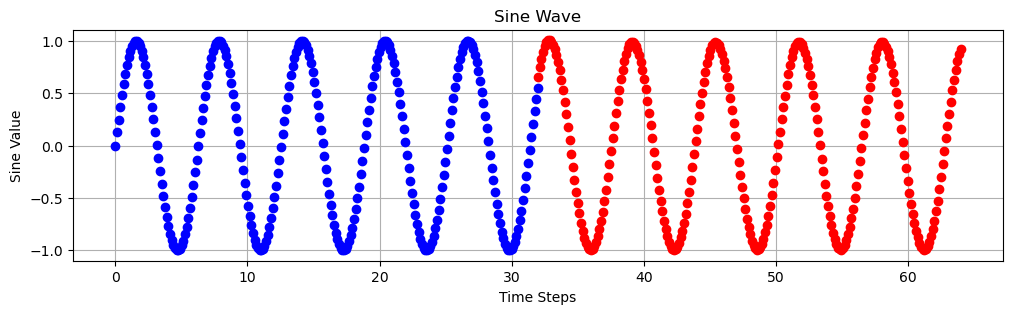

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(x, y, 'bo')
plt.plot(x_pred, y_pred_hc, 'ro')
plt.xlabel("Time Steps")
plt.ylabel("Sine Value")
plt.title("Sine Wave")
plt.grid(True)
plt.show()

In [21]:
set_random_seed(42)

In [22]:
for epoch in tqdm(range(num_epochs)):
    for data_batch, label_batch in zip(data_loader, label_loader):
        ptOPTIM.zero_grad()
        ptLSTM.train()
        pt_output_hidden, (pt_last_hidden, pt_last_cell) = ptLSTM(data_batch)
        pt_loss = ptLOSS(pt_last_hidden.squeeze(0), label_batch)
        pt_loss.backward()
        ptOPTIM.step()

100%|██████████| 512/512 [00:12<00:00, 41.10it/s]


In [23]:
ptLSTM.eval()
with torch.no_grad():
    x_pred = torch.linspace(32, 64, time_steps_pred)
    y_pred_pt = y.clone()
    y_true_pt = torch.sin(x_pred)
    for time_step in range(time_steps_pred):
        data = y_pred_pt[-window_size:]
        data_tensor = data.unsqueeze(-1)
        pt_output_hidden, (pt_last_hidden, _) = ptLSTM(data_tensor)
        pt_last_hidden = pt_last_hidden.squeeze().unsqueeze(0)
        y_pred_pt = torch.cat([y_pred_pt, pt_last_hidden])
    y_pred_pt = y_pred_pt[time_steps:]

In [24]:
with torch.no_grad():
    loss_pt = ptLOSS(y_pred_pt, y_true_pt)
print(loss_pt)

tensor(0.0040)


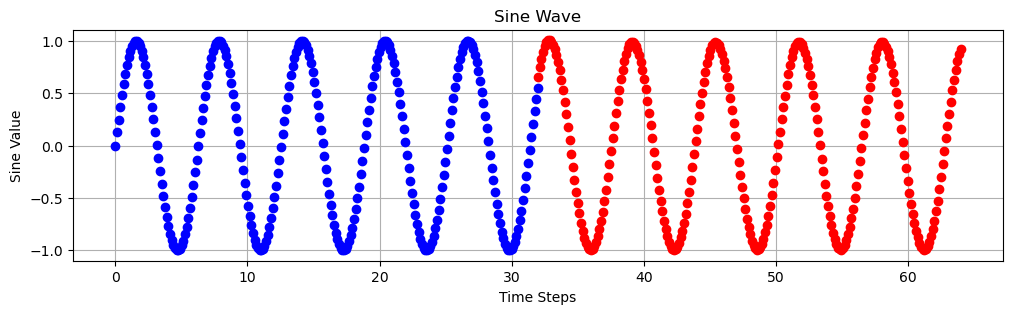

In [25]:
plt.figure(figsize=(12, 3))
plt.plot(x, y, 'bo')
plt.plot(x_pred, y_pred_pt, 'ro')
plt.xlabel("Time Steps")
plt.ylabel("Sine Value")
plt.title("Sine Wave")
plt.grid(True)
plt.show()

In [26]:
set_random_seed(42)

In [27]:
for epoch in tqdm(range(num_epochs)):
    for data_batch, label_batch in zip(data_loader, label_loader):
        nnOPTIM.zero_grad()
        nnLSTM.train()
        nn_output_hidden, (nn_last_hidden, nn_last_cell) = nnLSTM(data_batch)
        nn_loss = nnLOSS(nn_last_hidden.squeeze(0), label_batch)
        nn_loss.backward()
        nnOPTIM.step()

100%|██████████| 512/512 [00:12<00:00, 41.00it/s]


In [28]:
nnLSTM.eval()
with torch.no_grad():
    x_pred = torch.linspace(32, 64, time_steps_pred)
    y_pred_nn = y.clone()
    y_true_nn = torch.sin(x_pred)
    for time_step in range(time_steps_pred):
        data = y_pred_nn[-window_size:]
        data_tensor = data.unsqueeze(-1)
        nn_output_hidden, (nn_last_hidden, _) = nnLSTM(data_tensor)
        nn_last_hidden = nn_last_hidden.squeeze().unsqueeze(0)
        y_pred_nn = torch.cat([y_pred_nn, nn_last_hidden])
    y_pred_nn = y_pred_nn[time_steps:]

In [29]:
with torch.no_grad():
    loss_nn = nnLOSS(y_pred_nn, y_true_nn)
print(loss_nn)

tensor(0.0040)


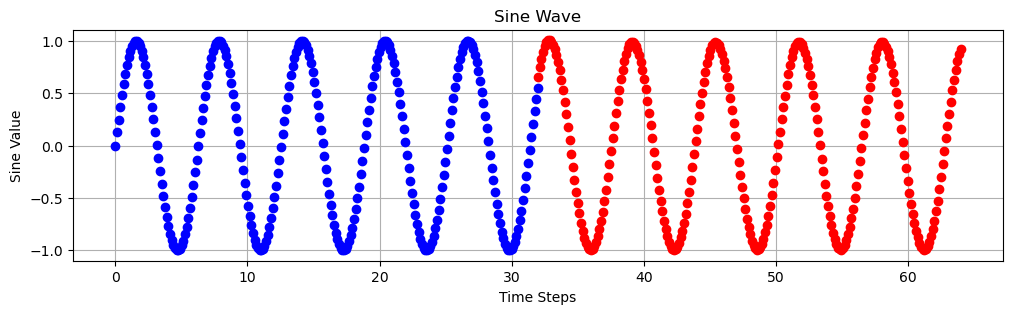

In [30]:
plt.figure(figsize=(12, 3))
plt.plot(x, y, 'bo')
plt.plot(x_pred, y_pred_nn, 'ro')
plt.xlabel("Time Steps")
plt.ylabel("Sine Value")
plt.title("Sine Wave")
plt.grid(True)
plt.show()

In [31]:
print("LSTMLayerHiddenCell:")
print("y_pred close: ", torch.allclose(y_pred_hc, y_pred_nn))
print("forward input-hidden weights close: ", torch.allclose(hcLSTM.forward_input_weights, nnLSTM.weight_ih_l0))
print("forward hidden-hidden weights close: ", torch.allclose(hcLSTM.forward_hidden_weights, nnLSTM.weight_hh_l0))
print("forward input-hidden bias close: ", torch.allclose(hcLSTM.forward_input_bias, nnLSTM.bias_ih_l0))
print("forward hidden-hidden bias close: ", torch.allclose(hcLSTM.forward_hidden_bias, nnLSTM.bias_hh_l0))
print("forward projection weights close: ", torch.allclose(hcLSTM.forward_projection_weights, nnLSTM.weight_hr_l0))

LSTMLayerHiddenCell:
y_pred close:  False
forward input-hidden weights close:  True
forward hidden-hidden weights close:  True
forward input-hidden bias close:  False
forward hidden-hidden bias close:  True
forward projection weights close:  True


In [32]:
print("LSTMLayer:")
print("y_pred equal: ", torch.equal(y_pred_pt, y_pred_nn))
print("forward input-hidden weights equal: ", torch.equal(ptLSTM.forward_input_weights, nnLSTM.weight_ih_l0))
print("forward hidden-hidden weights equal: ", torch.equal(ptLSTM.forward_hidden_weights, nnLSTM.weight_hh_l0))
print("forward input-hidden bias equal: ", torch.equal(ptLSTM.forward_input_bias, nnLSTM.bias_ih_l0))
print("forward hidden-hidden bias equal: ", torch.equal(ptLSTM.forward_hidden_bias, nnLSTM.bias_hh_l0))
print("forward projection weights equal: ", torch.equal(ptLSTM.forward_projection_weights, nnLSTM.weight_hr_l0))

LSTMLayer:
y_pred equal:  True
forward input-hidden weights equal:  True
forward hidden-hidden weights equal:  True
forward input-hidden bias equal:  True
forward hidden-hidden bias equal:  True
forward projection weights equal:  True


In [34]:
hcLSTM.set_parameters(ptLSTM.get_parameters())

In [35]:
print("LSTMLayerHiddenCell:")
print("forward input-hidden weights equal: ", torch.equal(hcLSTM.forward_input_weights, nnLSTM.weight_ih_l0))
print("forward hidden-hidden weights equal: ", torch.equal(hcLSTM.forward_hidden_weights, nnLSTM.weight_hh_l0))
print("forward input-hidden bias equal: ", torch.equal(hcLSTM.forward_input_bias, nnLSTM.bias_ih_l0))
print("forward hidden-hidden bias equal: ", torch.equal(hcLSTM.forward_hidden_bias, nnLSTM.bias_hh_l0))
print("forward projection weights equal: ", torch.equal(hcLSTM.forward_projection_weights, nnLSTM.weight_hr_l0))

LSTMLayerHiddenCell:
forward input-hidden weights equal:  True
forward hidden-hidden weights equal:  True
forward input-hidden bias equal:  True
forward hidden-hidden bias equal:  True
forward projection weights equal:  True


In [36]:
hcLSTM.eval()
with torch.no_grad():
    x_pred = torch.linspace(32, 64, time_steps_pred)
    y_pred_hc = y.clone()
    y_true_hc = torch.sin(x_pred)
    for time_step in range(time_steps_pred):
        data = y_pred_hc[-window_size:]
        data_tensor = data.unsqueeze(-1)
        (_, _), (hc_last_hidden, _) = hcLSTM(data_tensor)
        hc_last_hidden = hc_last_hidden.squeeze().unsqueeze(0)
        y_pred_hc = torch.cat([y_pred_hc, hc_last_hidden])
    y_pred_hc = y_pred_hc[time_steps:]

In [37]:
with torch.no_grad():
    loss_hc = hcLOSS(y_pred_hc, y_true_hc)
print(loss_hc)

tensor(0.0040)


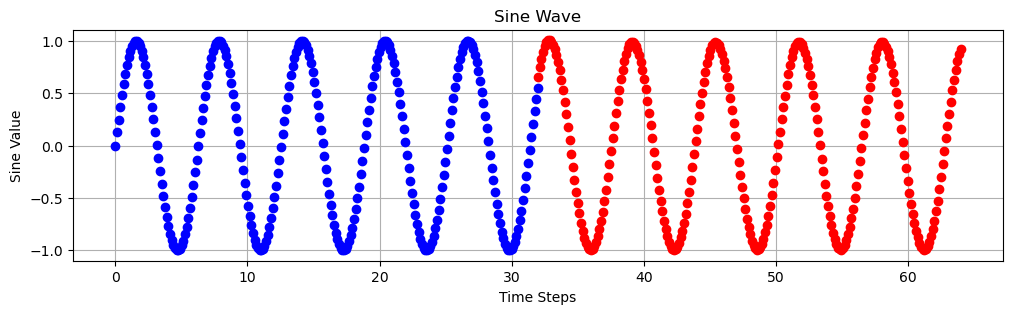

In [38]:
plt.figure(figsize=(12, 3))
plt.plot(x, y, 'bo')
plt.plot(x_pred, y_pred_hc, 'ro')
plt.xlabel("Time Steps")
plt.ylabel("Sine Value")
plt.title("Sine Wave")
plt.grid(True)
plt.show()

In [41]:
print("LSTMLayerHiddenCell:")
print("y_pred equal: ", torch.allclose(y_pred_hc, y_pred_pt))

LSTMLayerHiddenCell:
y_pred equal:  False


In [44]:
diff = y_pred_hc - y_pred_pt
print(torch.abs(diff).max())

tensor(1.7881e-06)
